In [2]:
import gc
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt
from logzero import logger

n_thread = 4

In [3]:
%%time
click_data = pd.concat([
    pd.read_feather("../data/basic_table").astype("float32"),
    pd.read_feather("../data/next_prev_channels").astype("float32"),
], axis=1)

CPU times: user 17 s, sys: 25 s, total: 42 s
Wall time: 4min 40s


In [5]:
click_data["dow"] = pd.read_feather("../data/time_table")["dow"]

In [6]:
click_data.columns

Index(['app', 'channel', 'click_id', 'device', 'ip', 'is_attributed', 'os',
       'next_channel_by_app', 'prev_channel_by_app', 'next_channel_by_device',
       'prev_channel_by_device', 'next_channel_by_ip', 'prev_channel_by_ip',
       'next_channel_by_os', 'prev_channel_by_os', 'next_channel_by_ip_os',
       'prev_channel_by_ip_os', 'next_channel_by_ip_device',
       'prev_channel_by_ip_device', 'next_channel_by_ip_app',
       'prev_channel_by_ip_app', 'next_channel_by_os_device',
       'prev_channel_by_os_device', 'next_channel_by_os_app',
       'prev_channel_by_os_app', 'next_channel_by_device_app',
       'prev_channel_by_device_app', 'next_channel_by_ip_os_device',
       'prev_channel_by_ip_os_device', 'next_channel_by_ip_os_app',
       'prev_channel_by_ip_os_app', 'next_channel_by_ip_device_app',
       'prev_channel_by_ip_device_app', 'next_channel_by_os_device_app',
       'prev_channel_by_os_device_app', 'next_channel_by_ip_os_device_app',
       'prev_channel_by_ip_

In [7]:
click_data.drop(columns=['app', 'channel', 'device', 'ip', 'os'], inplace=True)

In [8]:
%%time
logger.info("Splitting data...")
click_data.drop(columns=["click_id"], inplace=True)
logger.info("dropped")
train = click_data[click_data["dow"] < 3]
logger.info("created train")
valid = click_data[click_data["dow"] == 3]
logger.info("created valid")

del click_data
gc.collect()

[I 180429 12:46:46 <timed exec>:1] Splitting data...
[I 180429 12:46:58 <timed exec>:3] dropped
[I 180429 12:47:12 <timed exec>:5] created train
[I 180429 12:47:18 <timed exec>:7] created valid


CPU times: user 19.4 s, sys: 13.3 s, total: 32.7 s
Wall time: 32.5 s


In [9]:
%%time
y_train = train["is_attributed"].astype("int")
train.drop(columns=["is_attributed"], inplace=True)

y_valid = valid["is_attributed"].astype("int")
valid.drop(columns=["is_attributed"], inplace=True)
gc.collect()

CPU times: user 6.45 s, sys: 5.62 s, total: 12.1 s
Wall time: 12 s


In [10]:
%%time
logger.info("Generating matrix...")
dtrain = xgb.DMatrix(train, y_train)
logger.info("created train")
dvalid = xgb.DMatrix(valid, y_valid)
logger.info("created test")

del train, y_train, valid, y_valid
gc.collect()

[I 180429 12:47:30 <timed exec>:1] Generating matrix...
[I 180429 12:49:54 <timed exec>:3] created train
[I 180429 12:50:22 <timed exec>:5] created test


CPU times: user 51.8 s, sys: 1min 59s, total: 2min 51s
Wall time: 2min 51s


In [11]:
%%time
logger.info("Validating...")
params = {'eta': 0.6,
          'tree_method': "hist",
          'grow_policy': "lossguide",
          'max_leaves': 1400,
          'max_depth': 0,
          'subsample': 0.9,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'min_child_weight': 0,
          'alpha': 4,
          'objective': 'binary:logistic',
          'scale_pos_weight': 9,
          'eval_metric': 'auc',
          'nthread': n_thread,
          'random_state': 99,
          'silent': False}
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params,
                  dtrain,
                  200,
                  watchlist,
                  maximize=True,
                  early_stopping_rounds=25,
                  verbose_eval=5)

[I 180429 12:50:22 <timed exec>:1] Validating...


[0]	train-auc:0.941915	valid-auc:0.933609
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[5]	train-auc:0.977934	valid-auc:0.96823
[10]	train-auc:0.981566	valid-auc:0.969244
[15]	train-auc:0.983415	valid-auc:0.96774
[20]	train-auc:0.982608	valid-auc:0.964075
[25]	train-auc:0.982164	valid-auc:0.961738
[30]	train-auc:0.981335	valid-auc:0.959067
Stopping. Best iteration:
[9]	train-auc:0.982537	valid-auc:0.971423

CPU times: user 2h 25min 58s, sys: 48.9 s, total: 2h 26min 47s
Wall time: 43min 10s


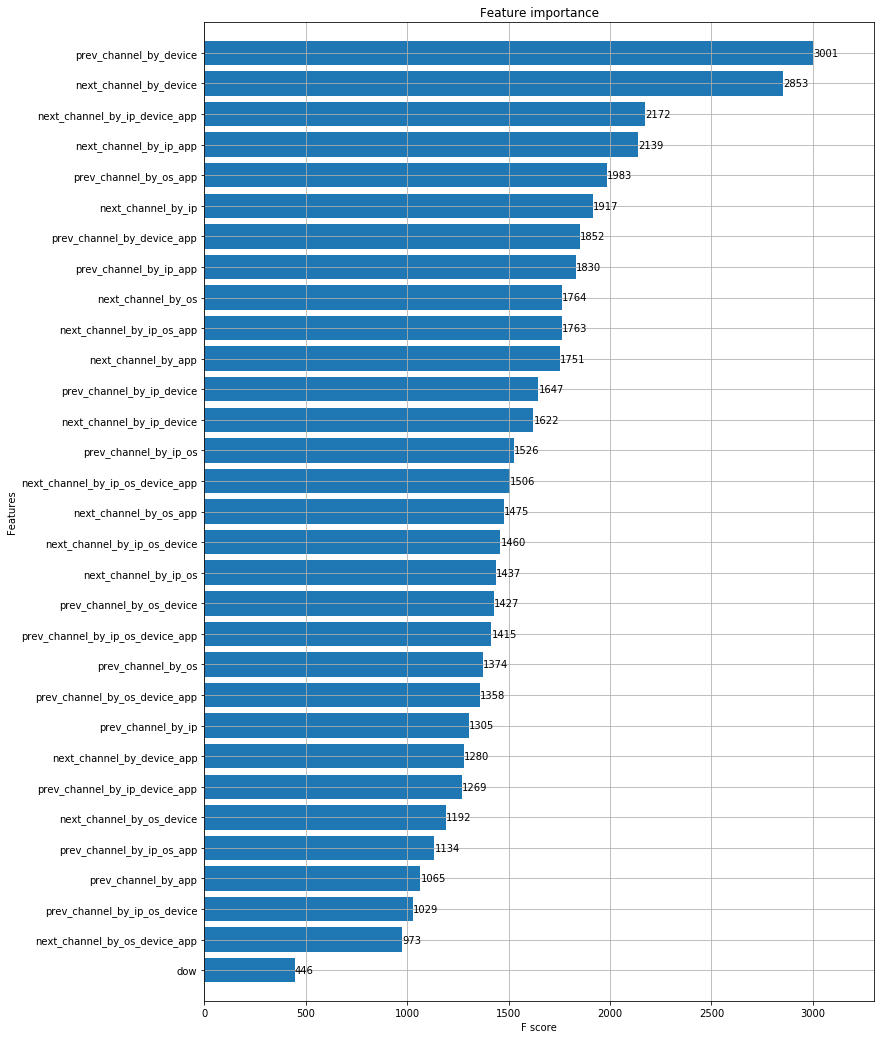

In [12]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [23]:
df = pd.read_feather("../data/basic_table")

In [24]:
df["dow"] = pd.read_feather("../data/time_table")["dow"]

In [25]:
df = df[df["dow"]==3]

In [26]:
df ["prediction"] = model.predict(dvalid, ntree_limit=model.best_ntree_limit)

In [27]:
df["abs"] = np.abs(df["is_attributed"] - df["prediction"])

In [29]:
df.sort_values(by=["abs"], ascending=False, inplace=True)

In [31]:
import seaborn as sns

In [33]:
df.columns

Index(['app', 'channel', 'click_id', 'device', 'ip', 'is_attributed', 'os',
       'dow', 'prediction', 'abs'],
      dtype='object')

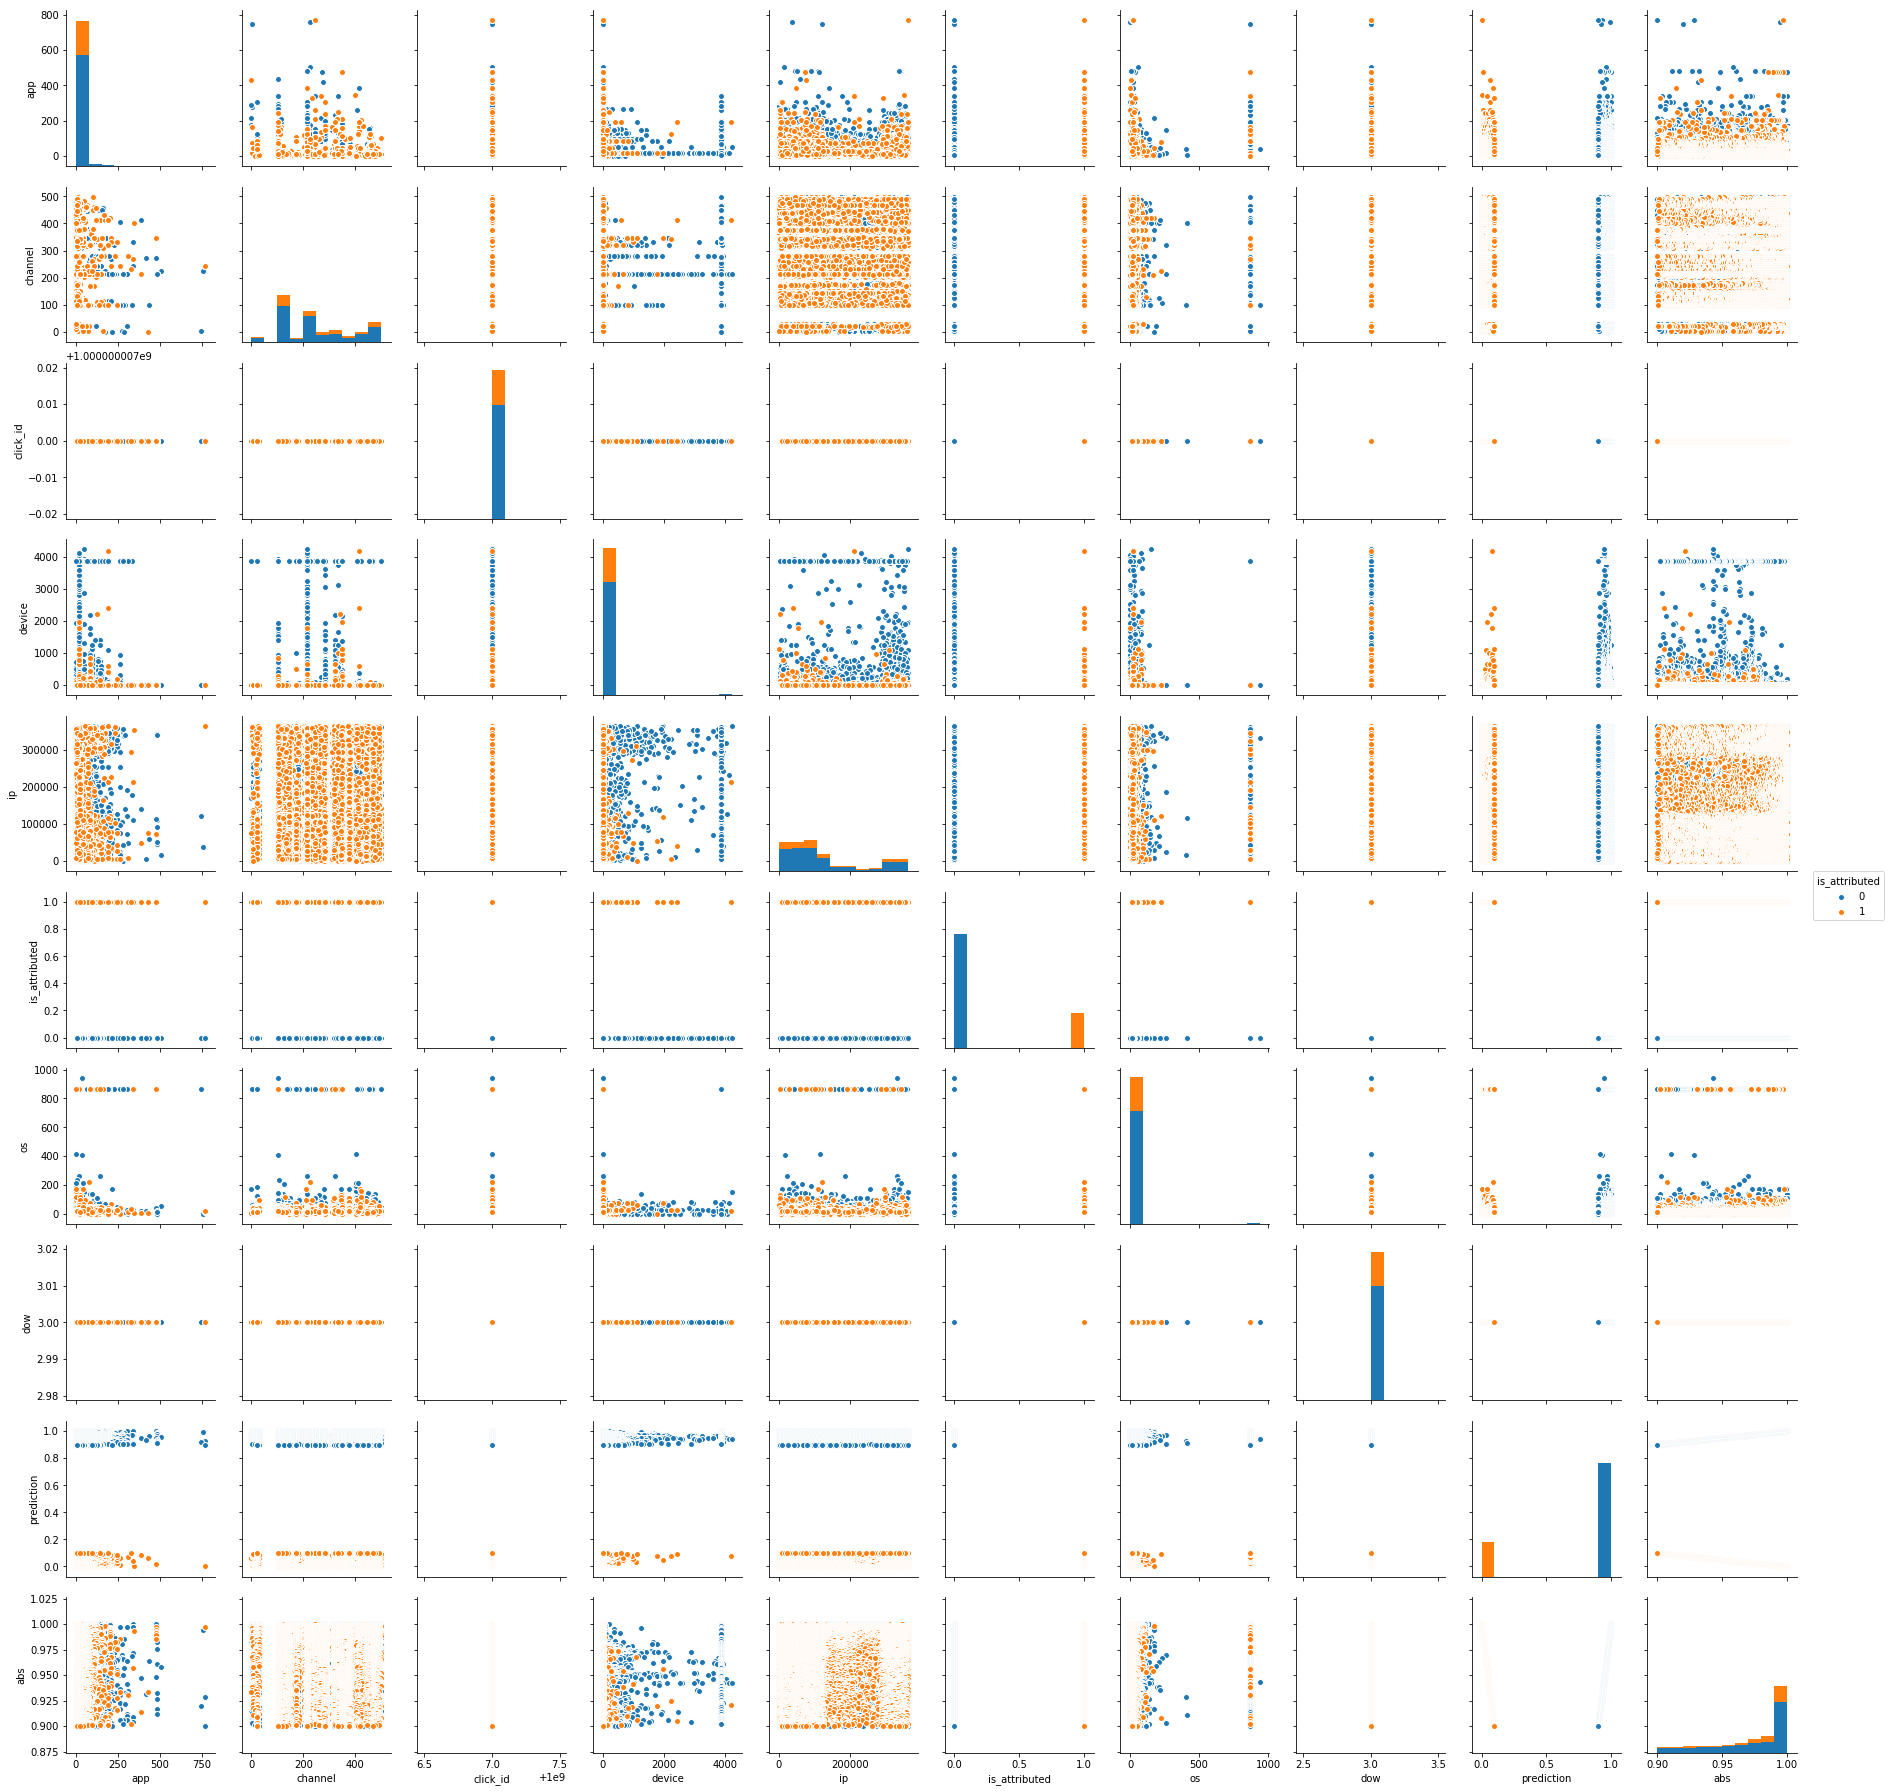

In [39]:
sns.pairplot(df[df["abs"]>0.9], hue="is_attributed")

KeyboardInterrupt: 